In [1]:

import os
import sys
import torch
import numpy as np
import torch.nn as nn
from keras import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append("..")

from src import metrics, callbacks
from src.utils import data_analysis, device
from src.architectures.sequential import Sequential

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'fashion_mnist_classifier.pt')

# Create a directory for the model if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

In [3]:
train_test_split_pct = 0.1 # Percentage of samples to use for testing
train_valid_split = 0.1 # Percentage of samples to use for validation
learning_rate = 1e-3 # Learning rate for the optimizer
batch_size = 256 # Number of samples to use for each batch
epochs = 100 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility

In [4]:
# Set the seed for reproducibility
torch.manual_seed(seed);

### Data loading

In [5]:
# Load the digits dataset
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Add the channel dimension to the images
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Extract the number of classes in the dataset
num_classes = len(np.unique(train_labels))

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=train_test_split_pct, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split, shuffle=True)

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (48600, 28, 28, 1) (48600,)
Validation set: (5400, 28, 28, 1) (5400,)
Testing set: (6000, 28, 28, 1) (6000,)


In [6]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

### Data Preprocessing

In [7]:
# Normalization
def normalize(X: torch.Tensor) -> torch.Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [8]:
# Convert the target values to one-hot encoded vectors
y_train_encoded = F.one_hot(y_train, num_classes=num_classes)
y_valid_encoded = F.one_hot(y_valid, num_classes=num_classes)

# Print one sample encoding
print("Sample target value:", y_train[0].item())
print("One-hot encoded value:", y_train_encoded[0])

Sample target value: 1
One-hot encoded value: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


### Data visualization

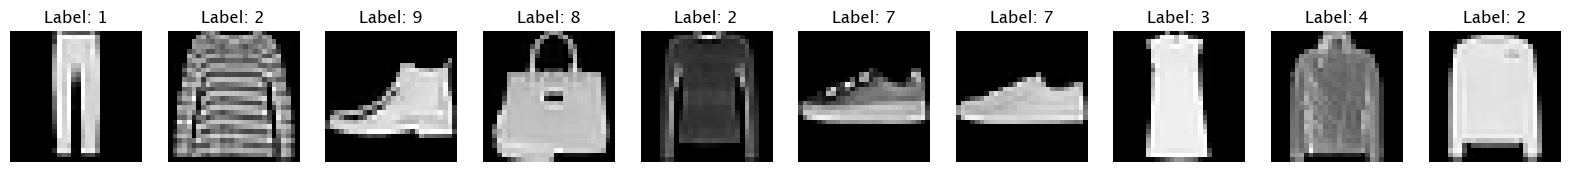

In [9]:
def plot_samples(samples: list[np.ndarray], labels: list[np.ndarray]) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Plot the samples in a grid
    _, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i][0], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
        
# Plot the first 10 samples
plot_samples(list(X_train.cpu().numpy()[:10]), list(y_train.cpu().numpy()[:10]))

### Building the model

In [10]:
# Building the model
model = Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.Dropout(p=0.1),
    nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.Dropout(p=0.1),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=784),
    nn.Linear(in_features=784, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=num_classes),
    nn.Softmax(dim=1)
)

# Move the model to the appropriate device
model = model.to(device)

# Initialize the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Initializing the model

In [11]:
# Display the model summary
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=784, out_features=64, bias=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=10, bias=True)
  (13): Softmax(dim=1)
)

### Training the model

In [12]:
history = model.fit(
    X_train = X_train, 
    y_train = y_train,
    optimizer = optimizer,
    loss_fn = loss_fn,
    X_valid = X_valid,
    y_valid = y_valid,
    batch_size = batch_size,
    epochs = epochs,
    metrics = [metrics.accuracy],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/100 --> loss: 1.7151 - accuracy: 0.7694 | Validation loss: 1.6167 - Validation accuracy: 0.8552                     
Epoch 2/100 --> loss: 1.6030 - accuracy: 0.8654 | Validation loss: 1.5850 - Validation accuracy: 0.8795                     
Epoch 3/100 --> loss: 1.5829 - accuracy: 0.8823 | Validation loss: 1.5633 - Validation accuracy: 0.9009                     
Epoch 4/100 --> loss: 1.5704 - accuracy: 0.8947 | Validation loss: 1.5642 - Validation accuracy: 0.8990                     
Epoch 5/100 --> loss: 1.5639 - accuracy: 0.8997 | Validation loss: 1.5549 - Validation accuracy: 0.9074                     
Epoch 6/100 --> loss: 1.5595 - accuracy: 0.9036 | Validation loss: 1.5502 - Validation accuracy: 0.9113                     
Epoch 7/100 --> loss: 1.5554 - accuracy: 0.9083 | Validation loss: 1.5496 - Validation accuracy: 0.9112                     
Epoch 8/100 --> loss: 1.5518 - accuracy: 0.9116 | Validation loss: 1.5461 - Validation accuracy: 0.9160                     


In [13]:
# Save the model
torch.save(model.state_dict(), model_path)

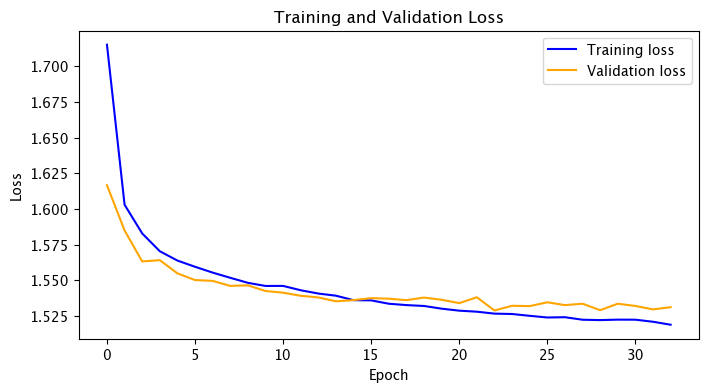

In [14]:
# Plot the training and validation loss
data_analysis.plot_history(history["loss"].numpy(), history["val_loss"].numpy(), "Training and Validation Loss", "Epoch", "Loss")

### Evaluation

In [15]:
# Disable gradient computation
with torch.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions = model(X_test)

# Apply the argmax function to the predictions
predictions = torch.argmax(predictions, dim=1)

Accuracy: 0.93


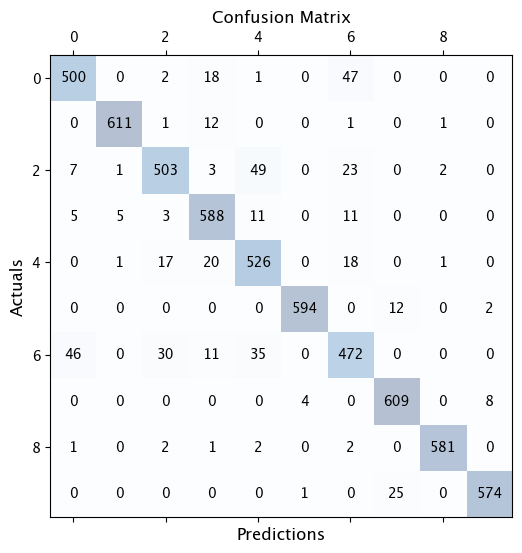

In [16]:
# Compute the accuracy
accuracy = metrics.accuracy(y_test, predictions)
confusion_matrix = metrics.confusion_matrix(num_classes, y_test, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy.item():.2f}")

# Plot the confusion matrix
data_analysis.plot_confusion_matrix(confusion_matrix.numpy())